# 关注公众号【Python读财】，选择“星标”公众号，重磅干货，第一时间送达

![](https://upload-images.jianshu.io/upload_images/8316927-0fb816f497f6e7f5.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

# 导包

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tushare as ts
from tqdm import tqdm_notebook
import warnings
import time
%matplotlib inline

plt.rcParams['font.sans-serif']=['FangSong'] 
plt.rcParams['axes.unicode_minus']=False
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",None)
pro = ts.pro_api()

# 数据整理

In [18]:
cb_basic_df = pro.cb_basic(fields="ts_code,bond_short_name,stk_code,list_date,conv_price")
cb_half_year = cb_basic_df[cb_basic_df["list_date"]>="2019-09-01"]
cb_half_year.sort_values(by="list_date",inplace=True)
cb_half_year.reset_index(inplace=True,drop=True)
cb_half_year = cb_half_year.iloc[:len(cb_half_year)-3]

cb_half_year["stock_price"] = np.nan
cb_half_year["cb_price"] = np.nan
for i in tqdm_notebook(range(len(cb_half_year))):
    stock_code = cb_half_year.loc[i,"stk_code"]
    cb_code = cb_half_year.loc[i,"ts_code"]
    date = cb_half_year.loc[i,"list_date"].replace("-","")
    cb_half_year.loc[i,"stock_price"] = ts.pro_bar(ts_code=stock_code, adj='qfq', start_date=date, end_date=date)["close"].values[0]
    cb_half_year.loc[i,"cb_price"] = pro.cb_daily(ts_code=cb_code,trade_date=date)["close"].values[0]
    time.sleep(1)

issue_df = pro.cb_issue(fields="onl_name,shd_ration_record_date,shd_ration_pay_date,shd_ration_ratio").dropna()
issue_df["onl_name"] = issue_df["onl_name"].map(lambda x: x.replace("发债","转债") if "发债" in x else x)
cb_half_year = cb_half_year.merge(issue_df,how="left",left_on="bond_short_name",right_on="onl_name")
cb_half_year.drop(columns = ["onl_name"],inplace=True)

cb_half_year.iloc[66,[7,8,9]] = ["20200110","20200113",1.0870]

cb_half_year["shd_ration_ratio"] = cb_half_year["shd_ration_ratio"].astype("float")

cb_half_year["shd_ration_record_date"] = cb_half_year["shd_ration_record_date"].astype(str)
cb_half_year["shd_ration_pay_date"] = cb_half_year["shd_ration_pay_date"].astype(str)

cb_half_year.drop(columns=["record_date_price","pay_date_price"],inplace=True)

cb_half_year.dropna(inplace=True)

cb_half_year.reset_index(drop=True,inplace=True)

cb_half_year["record_date_price"] = np.nan
cb_half_year["record_date_price"] = np.nan
for i in tqdm_notebook(range(len(cb_half_year))):
    stock_code = cb_half_year.loc[i,"stk_code"]
    record_date = cb_half_year.loc[i,"shd_ration_record_date"]
    pay_date = cb_half_year.loc[i,"shd_ration_pay_date"]
    cb_half_year.loc[i,"record_date_price"] = ts.pro_bar(ts_code=stock_code, adj='qfq', start_date=record_date, end_date=record_date)["open"].values[0]
    cb_half_year.loc[i,"pay_date_price"] = ts.pro_bar(ts_code=stock_code, adj='qfq', start_date=pay_date, end_date=pay_date)["open"].values[0]
    time.sleep(1)

df_zq = pro.cb_issue(fields="ts_code,onl_winning_rate")
cb_half_year = cb_half_year.merge(df_zq,how="left",left_on="ts_code",right_on="ts_code")

df = cb_half_year.drop(columns=["conv_price","stock_price","shd_ration_record_date","shd_ration_pay_date"])

df.to_pickle("./data/qqps_data.pkl")

# 分析

## 近半年可转债上市首日涨幅

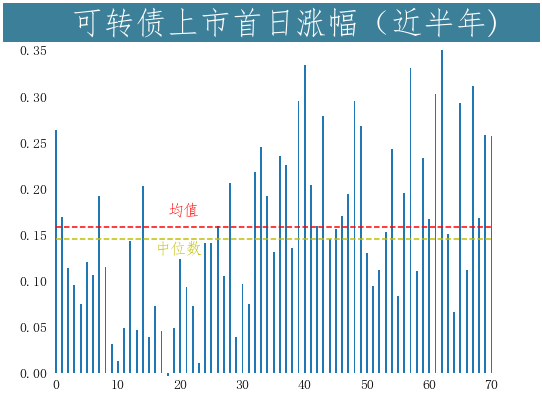

In [238]:
cb_zf = ((cb_half_year["cb_price"]-100)/100).values
fig,ax = plt.subplots(figsize=(8,6))
fig.text(x=0.05, y=0.92, s='    可转债上市首日涨幅（近半年)  ', fontsize=32, 
         weight='bold', color='white', backgroundcolor='#3c7f99')
ax.bar(list(range(len(cb_zf))),cb_zf,width=0.3)
ax.tick_params(axis="both",labelsize=14,length=0)
ax.hlines(np.mean(cb_zf),xmin=0,xmax=70,linestyles="--",colors="r")
ax.text(18,0.17,"均值",fontdict={'size':16,"color":"red"})
ax.hlines(np.median(cb_zf),xmin=0,xmax=70,linestyles="--",colors="y")
ax.text(16,0.13,"中位数",fontdict={'size':16,"color":"y"})
ax.margins(0.01,0)
plt.box(False)

先来看看可转债近半年来的上市首日涨跌幅状况，上市首日涨幅的均值和中位数均位于15%上下，整体的收益率情况还是比较可观的。另外，图中的样本是按照时间顺序进行排序，所以可以看出最近三个月的整体收益水平优于去年的四季度。乍一看这钱还挺好赚的，但只要有过可转债打新经验的朋友就知道，打新的中签率是很低的。

## 可转债中签率（单位%）

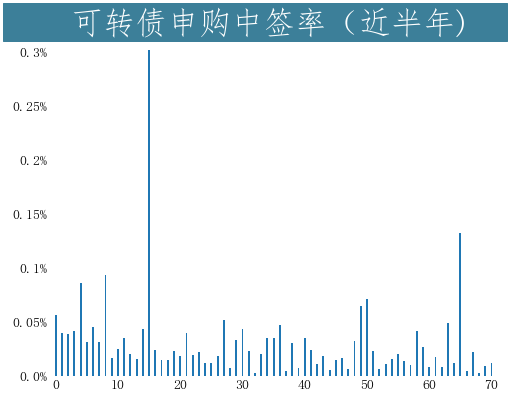

In [244]:
cb_zql = cb_half_year.onl_winning_rate.values
mean_cb_zql = np.mean(cb_zql)
fig,ax = plt.subplots(figsize=(8,6))
fig.text(x=0.05, y=0.92, s='    可转债申购中签率（近半年)  ', fontsize=32, 
         weight='bold', color='white', backgroundcolor='#3c7f99')
ax.bar(list(range(len(cb_zql))),cb_zql,width=0.3)
ax.tick_params(axis="both",labelsize=14,length=0)
ax.margins(0.01,0)
ax.set_yticklabels([str(np.round(0.05*i,2))+"%" for i in range(7)])
plt.box(False)

从图中可以看到，中签率并不高，最高的0.3%意味着人均可以中3签，而大多数情况下中签率低于0.05%，即人均中0.5签。而且一般情况下中了的话也就一签，总共1000元，按15%的平均收益水平来算，也就小赚150块。

受限于较低的中签率，如果想要获得更多的转债博取相应的收益，也就只有抢权配售这条路可以走了，下面就看看抢权配售能够带来多大收益，值不值得参与。

## 配售收益率、正股波动收益率、总收益率

一般转债在获得批文后的发行流程为：

![发行流程.png](https://upload-images.jianshu.io/upload_images/8316927-5cc07cbc2bbd3b1a.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

在网上申购之前，股东可以按照其持有的股份按一定比例进行可转债的配售，由于投资者的抢权行为，在股权登记日正股有上涨的动力，而在申购日配售后则则会形成一定抛压，所以将此处的抢权配售策略定义为在股权登记日买入转债对应的正股，并在配售日当天参与网上配售并卖出股票，持股周期为一天，以这两日的开盘价计算收益率。

总而言之，抢权配售时需要承担一天股价波动的风险以博取可转债的收益。

这样一来，抢权配售的总收益率 = 转债收益率 + 持股期间正股收益率

转债收益率和持股期间正股收益率的计算公式如下：

转债收益率 = [每股配售比例/(每股股价+每股配售比例)]*(可转债上市首日收益率)

持股期间正股收益率 = （申购日正股开盘价-股权登记日正股开盘价）/(每股股价+每股配售比例)

按照这样的思路，计算得到抢权配售的收益率情况如下图所示

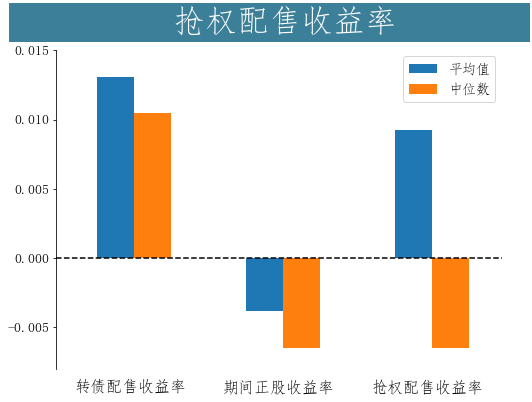

In [286]:
ps_profit_ratio = (cb_half_year["shd_ration_ratio"]/(cb_half_year["record_date_price"]+cb_half_year["shd_ration_ratio"]))*cb_zf
zg_profit_ratio = (cb_half_year["pay_date_price"]-cb_half_year["record_date_price"])/(cb_half_year["record_date_price"]+cb_half_year["shd_ration_ratio"])
total_profit_ratio = ps_profit_ratio+zg_profit_ratio

fig,ax = plt.subplots(figsize=(8,6))
fig.text(x=0.05, y=0.92, s='          抢权配售收益率        ', fontsize=32, 
         weight='bold', color='white', backgroundcolor='#3c7f99')
mean_list = [np.mean(ps_profit_ratio),np.mean(zg_profit_ratio),np.mean(total_profit_ratio)]
median_list = [np.median(ps_profit_ratio),np.median(zg_profit_ratio),np.median(zg_profit_ratio)]
ax.bar([0.8,2.8,4.8],mean_list,width=0.5,label="平均值")
ax.bar([1.3,3.3,5.3],median_list,width=0.5,label="中位数")
ax.hlines(0,xmin=0,xmax=6,linestyles="dashed")
ax.tick_params(axis="x",length=0)
ax.tick_params(axis="both",labelsize=14)
ax.set_xticklabels(labels=["","转债配售收益率","","期间正股收益率","","抢权配售收益率"],size=16)
ax.spines['left'].set_bounds(-0.008, 0.015)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.margins(0,0.1)
plt.legend(fontsize=14)

从数据结果来看，抢权配售总收益大多不理想，总收益率的均值约为1%，而中位数则为负值，说明某几次收益较高的抢权配售行为拉高了整体收益水平。将总收益率拆分来看，抢权配售的收益率主要被正股所拖累，配售得到的转债收益无法弥补正股的亏损。更进一步的原因可以由下图解释。

([<matplotlib.patches.Wedge at 0x2830fc31f60>,
 [Text(-0.3699632377845709, 1.0359185309125218, '转债部分占比'),
  Text(0.36996326203199353, -1.035918522252907, '正股部分占比')],
 [Text(-0.201798129700675, 0.56504647140683, '10.9%'),
  Text(0.2017981429265419, -0.5650464666834037, '89.1%')])

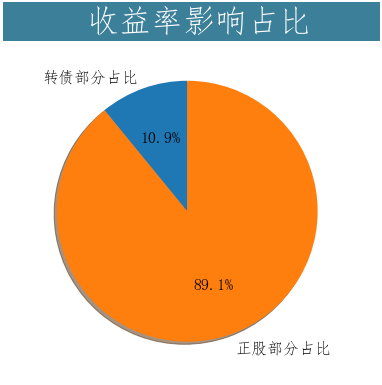

In [275]:
cb_ratio = np.mean(cb_half_year["shd_ration_ratio"]/cb_half_year["record_date_price"])
stock_ratio = 1-cb_ratio
fig, ax = plt.subplots(figsize=(8,6))
fig.text(x=0.2, y=0.92, s='     收益率影响占比    ', fontsize=32, 
         weight='bold', color='white', backgroundcolor='#3c7f99')
ax.pie([cb_ratio,stock_ratio], labels=["转债部分占比","正股部分占比"], autopct='%1.1f%%',
        shadow=True, startangle=90,textprops={"size":16})

从饼图的结果来看，正股损益的影响占抢权配售收益率影响的89.1%。举个例子，假设现在正股每股股价89.1元，每股可以配售10.9元的可转债，假设持有的可转债上市当日的涨跌幅为15%，只要正股次日跌幅为1.84%，可转债所赚取的收益便被正股损益所抹平，而正股次日下跌1.84%的可能性是非常大的。如果算上交易手续费，收益率水平会更低。

所以，从数据的角度来看，参与抢权配售并不是一个比较稳妥的博取收益的方式，还是老老实实参与打新吧。

![](https://upload-images.jianshu.io/upload_images/8316927-33a33e5473ec8358.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)